# Credit One: Credit Limits and Default

## Overview

I was asked to evaluate the customer information for Credit One's credit cards over a six-month period. This particular data is from April to September 2005. Ultimately, my goal was to create a machine learning algorithm to predict potential customers who are likely to default, and gauge how much credit to give the ones who would not default.

In [1]:
#import important programs
import numpy as np
import pandas as pd
import sqlalchemy as sal
from sqlalchemy import create_engine
import pymysql
import pandas_profiling as pp

D:\Users\jryba\anaconda3\envs\DataAnalyticsCourse\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The Data

Before cleaning, the data contained around 30200 observations.

In [2]:
credit=pd.read_csv('credit.csv')
pd.set_option('display.max_columns',None)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30204 entries, 0 to 30203
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MyUnknownColumn  30203 non-null  object
 1   X1               30204 non-null  object
 2   X2               30204 non-null  object
 3   X3               30204 non-null  object
 4   X4               30204 non-null  object
 5   X5               30204 non-null  object
 6   X6               30204 non-null  object
 7   X7               30204 non-null  object
 8   X8               30204 non-null  object
 9   X9               30204 non-null  object
 10  X10              30204 non-null  object
 11  X11              30204 non-null  object
 12  X12              30204 non-null  object
 13  X13              30204 non-null  object
 14  X14              30204 non-null  object
 15  X15              30204 non-null  object
 16  X16              30204 non-null  object
 17  X17              30204 non-null

In [3]:
credit.head()

,MyUnknownColumn,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,female,university,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,default
2,2,120000,female,university,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,default
3,3,90000,female,university,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
4,4,50000,female,university,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default


Immediately a few problems are apparent. The columns are not named properly and the data in the first index is what we want the columns to be named. I want to change the column names to the entries in the first column and then delete the first column. 

Looking at the accompanying pdf with the data, I noticed that the monthly columns were indexed so they go BACKWARDS in time. I will reindex the columns so they will go forwards instead. 

I can also go ahead and drop any duplicates and observations with null data.

In [4]:
credit=credit.drop(index=[0])
credit.columns = ['ID', 'Limit_bal', 'Gender', 'Education', 'Marriage', 'Age', 'Pay_Sept', 'Pay_Aug', 'Pay_Jul', 'Pay_Jun', 'Pay_May', 'Pay_Apr', 'Bill_Sept', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr', 'Pay_Amt_Sept', 'Pay_Amt_Aug', 'Pay_Amt_Jul', 'Pay_Amt_Jun', 'Pay_Amt_May', 'Pay_Amt_Apr', 'Default']
column_names = ['ID', 'Default', 'Limit_bal', 'Gender', 'Education', 'Marriage', 'Age', 'Pay_Apr', 'Pay_May', 'Pay_Jun', 'Pay_Jul', 'Pay_Aug', 'Pay_Sept', 'Bill_Apr', 'Bill_May', 'Bill_Jun', 'Bill_Jul', 'Bill_Aug', 'Bill_Sept', 'Pay_Amt_Apr', 'Pay_Amt_May', 'Pay_Amt_Jun', 'Pay_Amt_Jul', 'Pay_Amt_Aug', 'Pay_Amt_Sept']
credit = credit.reindex(columns=column_names)

credit=credit.dropna()
credit=credit.drop_duplicates() 
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 1 to 30203
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            30001 non-null  object
 1   Default       30001 non-null  object
 2   Limit_bal     30001 non-null  object
 3   Gender        30001 non-null  object
 4   Education     30001 non-null  object
 5   Marriage      30001 non-null  object
 6   Age           30001 non-null  object
 7   Pay_Apr       30001 non-null  object
 8   Pay_May       30001 non-null  object
 9   Pay_Jun       30001 non-null  object
 10  Pay_Jul       30001 non-null  object
 11  Pay_Aug       30001 non-null  object
 12  Pay_Sept      30001 non-null  object
 13  Bill_Apr      30001 non-null  object
 14  Bill_May      30001 non-null  object
 15  Bill_Jun      30001 non-null  object
 16  Bill_Jul      30001 non-null  object
 17  Bill_Aug      30001 non-null  object
 18  Bill_Sept     30001 non-null  object
 19  Pay_

In [5]:
credit['Default'].value_counts()

not default                   23364
default                        6636
default payment next month        1
Name: Default, dtype: int64

We can see that there is one more row with outlying values that we cannot use. I need to find it and drop it from the dataset.

In [6]:
credit.loc[credit['Default']=='default payment next month']

,ID,Default,Limit_bal,Gender,Education,Marriage,Age,Pay_Apr,Pay_May,Pay_Jun,Pay_Jul,Pay_Aug,Pay_Sept,Bill_Apr,Bill_May,Bill_Jun,Bill_Jul,Bill_Aug,Bill_Sept,Pay_Amt_Apr,Pay_Amt_May,Pay_Amt_Jun,Pay_Amt_Jul,Pay_Amt_Aug,Pay_Amt_Sept
203,ID,default payment next month,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0,BILL_AMT6,BILL_AMT5,BILL_AMT4,BILL_AMT3,BILL_AMT2,BILL_AMT1,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1


In [7]:
#dropping entry 203
credit=credit.drop(index=203)
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30203
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            30000 non-null  object
 1   Default       30000 non-null  object
 2   Limit_bal     30000 non-null  object
 3   Gender        30000 non-null  object
 4   Education     30000 non-null  object
 5   Marriage      30000 non-null  object
 6   Age           30000 non-null  object
 7   Pay_Apr       30000 non-null  object
 8   Pay_May       30000 non-null  object
 9   Pay_Jun       30000 non-null  object
 10  Pay_Jul       30000 non-null  object
 11  Pay_Aug       30000 non-null  object
 12  Pay_Sept      30000 non-null  object
 13  Bill_Apr      30000 non-null  object
 14  Bill_May      30000 non-null  object
 15  Bill_Jun      30000 non-null  object
 16  Bill_Jul      30000 non-null  object
 17  Bill_Aug      30000 non-null  object
 18  Bill_Sept     30000 non-null  object
 19  Pay_

Dropped! Now I have a nice even 30,000 entries to analyze. In the data.info, we can see the data types are all objects. In order to perform operations on them, I will need to change them to a float or a integer. Additionally, even though there are only 30,000 entries, the index goes up to 30203. I can reindex these so they are more even. 

First is to change the non-integer entries to integers. I will do this by assigning a number to the non-numeric data. 

In [8]:
credit['Gender']=credit['Gender'].replace('female','1')
credit['Gender']=credit['Gender'].replace('male','2')
credit['Education']=credit['Education'].replace('other','1')
credit['Education']=credit['Education'].replace('high school','2')
credit['Education']=credit['Education'].replace('university','3')
credit['Education']=credit['Education'].replace('graduate school','4')
credit['Default']=credit['Default'].replace('not default','1')
credit['Default']=credit['Default'].replace('default','2')
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30203
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            30000 non-null  object
 1   Default       30000 non-null  object
 2   Limit_bal     30000 non-null  object
 3   Gender        30000 non-null  object
 4   Education     30000 non-null  object
 5   Marriage      30000 non-null  object
 6   Age           30000 non-null  object
 7   Pay_Apr       30000 non-null  object
 8   Pay_May       30000 non-null  object
 9   Pay_Jun       30000 non-null  object
 10  Pay_Jul       30000 non-null  object
 11  Pay_Aug       30000 non-null  object
 12  Pay_Sept      30000 non-null  object
 13  Bill_Apr      30000 non-null  object
 14  Bill_May      30000 non-null  object
 15  Bill_Jun      30000 non-null  object
 16  Bill_Jul      30000 non-null  object
 17  Bill_Aug      30000 non-null  object
 18  Bill_Sept     30000 non-null  object
 19  Pay_

##### Numbers assigned to values
Gender:
    1 = Female,
    2 = Male

Education:
    1 = Other,
    2 = High School,
    3 = University,
    4 = Graduate

Default:
    1 = Did not default,
    2 = Defaulted
    
I will save this edited data as a csv. This will both reindex the data so the index matches the number of entries and change the object type to an integer.

In [9]:
credit.to_csv('credit_1.csv')

In [10]:
credit=pd.read_csv('credit_1.csv')
credit=credit.drop(columns='Unnamed: 0')
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            30000 non-null  int64
 1   Default       30000 non-null  int64
 2   Limit_bal     30000 non-null  int64
 3   Gender        30000 non-null  int64
 4   Education     30000 non-null  int64
 5   Marriage      30000 non-null  int64
 6   Age           30000 non-null  int64
 7   Pay_Apr       30000 non-null  int64
 8   Pay_May       30000 non-null  int64
 9   Pay_Jun       30000 non-null  int64
 10  Pay_Jul       30000 non-null  int64
 11  Pay_Aug       30000 non-null  int64
 12  Pay_Sept      30000 non-null  int64
 13  Bill_Apr      30000 non-null  int64
 14  Bill_May      30000 non-null  int64
 15  Bill_Jun      30000 non-null  int64
 16  Bill_Jul      30000 non-null  int64
 17  Bill_Aug      30000 non-null  int64
 18  Bill_Sept     30000 non-null  int64
 19  Pay_Amt_Apr   30000 non-n

Saving the data to a csv and then pulling it back out creates a new column. I deleted that column to keep the data concise. But we can see that the index range has been reset and all of the data types are integers.

The last thing to do is add columns. Some will have total values over the six-month period. It will help me compare the data using the amount data as a whole. The other columns I will add are sorting the age and the limit balance values into bins. This will help me see relationship patterns and later create prediction algorithms.

In [11]:
#adding total columns. Total bill, payment amount, payment status, and outstanding debt.
credit['Total_Bill'] = credit['Bill_Apr']+credit['Bill_May']+credit['Bill_Jun']+credit['Bill_Jul']+credit['Bill_Aug']+credit['Bill_Sept']
credit['Total_Pay_Amt'] = credit['Pay_Amt_Apr']+credit['Pay_Amt_May']+credit['Pay_Amt_Jun']+credit['Pay_Amt_Jul']+credit['Pay_Amt_Aug']+credit['Pay_Amt_Sept']
credit['Total_Pay'] = (credit['Pay_Apr']+credit['Pay_May']+credit['Pay_Jun']+credit['Pay_Jul']+credit['Pay_Aug']+credit['Pay_Sept'])
credit['Outstanding_Debt'] = credit['Total_Bill']-credit['Total_Pay_Amt']\

#binning ages
Age_Bins = pd.IntervalIndex.from_tuples([(10,20),(20,30),(30,40),(40,50),(50,60),
                                         (60,70),(70,80),(80,90)], closed='left')
credit['Age_Bins'] = pd.cut(credit['Age'],Age_Bins)
credit['Age_Bins']=credit['Age_Bins'].astype('string')
credit['Age_Bins']=credit['Age_Bins'].replace('[10, 20)','10')
credit['Age_Bins']=credit['Age_Bins'].replace('[20, 30)','20')
credit['Age_Bins']=credit['Age_Bins'].replace('[30, 40)','30')
credit['Age_Bins']=credit['Age_Bins'].replace('[40, 50)','40')
credit['Age_Bins']=credit['Age_Bins'].replace('[50, 60)','50')
credit['Age_Bins']=credit['Age_Bins'].replace('[60, 70)','60')
credit['Age_Bins']=credit['Age_Bins'].replace('[70, 80)','70')
credit['Age_Bins']=credit['Age_Bins'].replace('(80, 90)','80')
credit['Age_Bins']=credit['Age_Bins'].astype('int64')

#binning limit balances
Limit_Bins = pd.IntervalIndex.from_tuples([(10000,100000),(100000,200000),
                                               (200000,300000),(300000,400000),
                                               (400000,500000),(500000,600000),
                                               (600000,700000),(700000,800000),
                                               (800000,900000),(900000,1000001)],
                                          closed='left')
credit['Limit_Bins'] = pd.cut(credit['Limit_bal'],Limit_Bins)
credit['Limit_Bins']=credit['Limit_Bins'].astype('string')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[10000, 100000)','10000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[100000, 200000)','100000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[200000, 300000)','200000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[300000, 400000)','300000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[400000, 500000)','400000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[500000, 600000)','500000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[600000, 700000)','600000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[700000, 800000)','700000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[800000, 900000)','800000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[900000, 1000001)','900000')
credit['Limit_Bins']=credit['Limit_Bins'].astype('int64')

#reindexing columns
column_names = ['ID', 'Default', 'Limit_bal', 'Limit_Bins', 'Gender', 
                'Education', 'Marriage', 'Age', 'Age_Bins', 'Pay_Apr', 
                'Pay_May', 'Pay_Jun', 'Pay_Jul', 'Pay_Aug', 'Pay_Sept', 
                'Total_Pay','Bill_Apr', 'Bill_May', 'Bill_Jun', 'Bill_Jul', 
                'Bill_Aug', 'Bill_Sept', 'Total_Bill', 'Pay_Amt_Apr', 
                'Pay_Amt_May', 'Pay_Amt_Jun', 'Pay_Amt_Jul', 'Pay_Amt_Aug', 
                'Pay_Amt_Sept', 'Total_Pay_Amt','Outstanding_Debt']
credit = credit.reindex(columns=column_names)
credit.head()

,ID,Default,Limit_bal,Limit_Bins,Gender,Education,Marriage,Age,Age_Bins,Pay_Apr,Pay_May,Pay_Jun,Pay_Jul,Pay_Aug,Pay_Sept,Total_Pay,Bill_Apr,Bill_May,Bill_Jun,Bill_Jul,Bill_Aug,Bill_Sept,Total_Bill,Pay_Amt_Apr,Pay_Amt_May,Pay_Amt_Jun,Pay_Amt_Jul,Pay_Amt_Aug,Pay_Amt_Sept,Total_Pay_Amt,Outstanding_Debt
0,1,2,20000,10000,1,3,1,24,20,-2,-2,-1,-1,2,2,-2,0,0,0,689,3102,3913,7704,0,0,0,0,689,0,689,7015
1,2,2,120000,100000,1,3,2,26,20,2,0,0,0,2,-1,3,3261,3455,3272,2682,1725,2682,17077,2000,0,1000,1000,1000,0,5000,12077
2,3,1,90000,10000,1,3,2,34,30,0,0,0,0,0,0,0,15549,14948,14331,13559,14027,29239,101653,5000,1000,1000,1000,1500,1518,11018,90635
3,4,1,50000,10000,1,3,1,37,30,0,0,0,0,0,0,0,29547,28959,28314,49291,48233,46990,231334,1000,1069,1100,1200,2019,2000,8388,222946
4,5,1,50000,10000,2,3,1,57,50,0,0,0,-1,0,-1,-2,19131,19146,20940,35835,5670,8617,109339,679,689,9000,10000,36681,2000,59049,50290


## Exploratory Analysis

Our goal is to find out if we can predict who will default and give an algorithm to set a credit limit for those who will not default. In our data table, the dependent variables are the Default and Limit_bal columns.

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [13]:
credit.describe()

,ID,Default,Limit_bal,Limit_Bins,Gender,Education,Marriage,Age,Age_Bins,Pay_Apr,Pay_May,Pay_Jun,Pay_Jul,Pay_Aug,Pay_Sept,Total_Pay,Bill_Apr,Bill_May,Bill_Jun,Bill_Jul,Bill_Aug,Bill_Sept,Total_Bill,Pay_Amt_Apr,Pay_Amt_May,Pay_Amt_Jun,Pay_Amt_Jul,Pay_Amt_Aug,Pay_Amt_Sept,Total_Pay_Amt,Outstanding_Debt
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.00000,3.000000e+04,30000.000000,3.000000e+04,3.000000e+04
mean,15000.500000,1.221200,167484.322667,130316.666667,1.396267,3.157733,1.551867,35.485500,30.856667,-0.291100,-0.266200,-0.220667,-0.166200,-0.133767,-0.016700,-1.094633,38871.760400,40311.400967,43262.948967,4.701315e+04,49179.075167,51223.330900,2.698617e+05,5215.502567,4799.387633,4826.076867,5225.68150,5.921163e+03,5663.580500,3.165139e+04,2.382103e+05
std,8660.398374,0.415062,129747.661567,130564.037753,0.489129,0.744494,0.521970,9.217904,9.738717,1.149988,1.133187,1.169139,1.196868,1.197186,1.123802,5.893055,59554.107537,60797.155770,64332.856134,6.934939e+04,71173.768783,73635.860576,3.795643e+05,17777.465775,15278.305679,15666.159744,17606.96147,2.304087e+04,16563.280354,6.082768e+04,3.631651e+05
min,1.000000,1.000000,10000.000000,10000.000000,1.000000,1.000000,0.000000,21.000000,20.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-12.000000,-339603.000000,-81334.000000,-170000.000000,-1.572640e+05,-69777.000000,-165580.000000,-3.362590e+05,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,-2.671514e+06
25%,7500.750000,1.000000,50000.000000,10000.000000,1.000000,3.000000,1.000000,28.000000,20.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-5.000000,1256.000000,1763.000000,2326.750000,2.666250e+03,2984.750000,3558.750000,2.868800e+04,117.750000,252.500000,296.000000,390.00000,8.330000e+02,1000.000000,6.679750e+03,4.520750e+03
50%,15000.500000,1.000000,140000.000000,100000.000000,1.000000,3.000000,2.000000,34.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17071.000000,18104.500000,19052.000000,2.008850e+04,21200.000000,22381.500000,1.263110e+05,1500.000000,1500.000000,1500.000000,1800.00000,2.009000e+03,2100.000000,1.438300e+04,1.019230e+05
75%,22500.250000,1.000000,240000.000000,200000.000000,2.000000,4.000000,2.000000,41.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49198.250000,50190.500000,54506.000000,6.016475e+04,64006.250000,67091.000000,3.426265e+05,4000.000000,4031.500000,4013.250000,4505.00000,5.000000e+03,5006.000000,3.350350e+04,3.057178e+05
max,30000.000000,2.000000,1000000.000000,900000.000000,2.000000,4.000000,3.000000,79.000000,70.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,36.000000,961664.000000,927171.000000,891586.000000,1.664089e+06,983931.000000,964511.000000,5.263883e+06,528666.000000,426529.000000,621000.000000,896040.00000,1.684259e+06,873552.000000,3.764066e+06,4.116080e+06


Let's have a look at the dependent variables first.

Text(0.5, 1.0, 'Default by Percent')

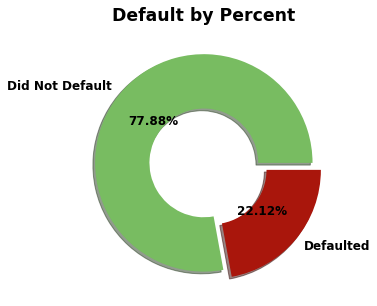

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(x=credit['Default'].value_counts(), colors=['#78BC61','#a9160c'], 
        labels=['Did Not Default','Defaulted'], autopct='%.2f%%', shadow=True,
           textprops={'size':'large','fontweight':'bold'}, explode=(0,.1),
       wedgeprops=dict(width=.5))
ax.set_title('Default by Percent',{'size':'xx-large','fontweight':'bold'})

Just over 22% of people defaulted. That's more than 1 in 5. While it's a small percentage, it is still too large to be good for Credit One. Can we find something to distinguish this group of people?

Text(0.5, 0, 'Total Payment Status')

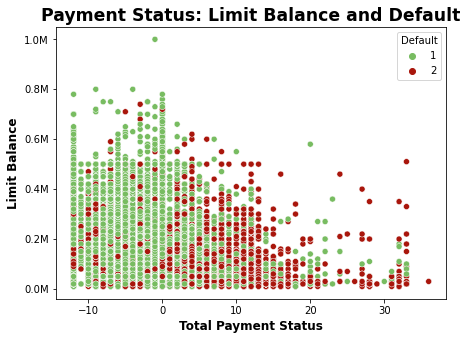

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(x=credit['Total_Pay'], y=credit['Limit_bal'], 
                hue=credit['Default'], palette=['#78BC61','#a9160c'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000000) + 'M'))
ax.set_title('Payment Status: Limit Balance and Default',{'size':'xx-large','fontweight':'bold'})
plt.ylabel('Limit Balance',{'size':'large','fontweight':'bold'})
plt.xlabel('Total Payment Status',{'size':'large','fontweight':'bold'})

The Pay columns are a measure of the payment status of the customer. The measurement scale for the repayment status is:

-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

Most people have a net 0 payment status.  Meaning they don't have a delay on their credit but they don't pay it early as well. People with a longer payment delay were more likely to default. While this is not too surprising, we can use it to determine whether someone is likely to do so in the future. 

There also aren't many limit balances above 500,000 overall. People with a longer delay also did not have a high credit limit. 

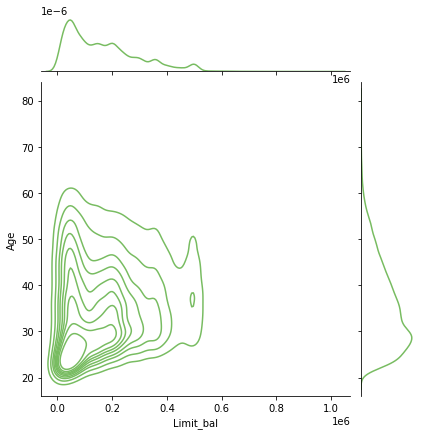

In [17]:
sns.jointplot(y=credit['Age'], x=credit['Limit_bal'], kind='kde', color='#78BC61')

The data in both groups is highly weighted in the lower end of the spectrum across all categories.

#### Limit Balance

Most of the data has a low limit balance. With less distinction in the lower end, it will make it difficult for the algorithm to sort the data. I suspect that it will sort data it is unsure of in the lower categories. This will make it more accurate on the low end but less accurate on the high end.

#### Default
We can see that at the lower end the group who defaulted is very similar to the group that didn't. Unfortunately, this is where most of our data lies. Most of the differences between people who defaulted and people who didn't are minimal, but with only two options to choose from I think I will be able to predict whether someone will default. 

The payment status is the variable that will help the most in determining who will default.

### Other Useful Information

This information isn't directly useful to predict the limit balance or default, but still could be useful to Credit One as a business.

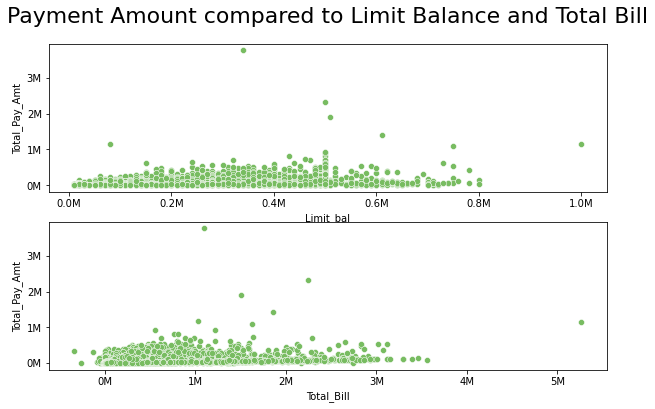

In [18]:
fig,(ax1,ax2)= plt.subplots(2,1, sharex=False, sharey=True, figsize=(10,6))
sns.scatterplot(y=credit['Total_Pay_Amt'], x=credit['Limit_bal'], ax=ax1, color='#78BC61')
plt.title("Payment Amount compared to Limit Balance and Total Bill", y=2.3, fontsize=22)
sns.scatterplot(y=credit['Total_Pay_Amt'], x=credit['Total_Bill'], ax=ax2, color='#78BC61')

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000000) + 'M'))



No matter the limit balance or total bill, the customer payment amount remains low. 

C:\Users\jryba\AppData\Local\Temp\ipykernel_9060\818560906.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  monthly.set_yticklabels(ylabels)


Text(0, 0.5, 'Amount (USD)')

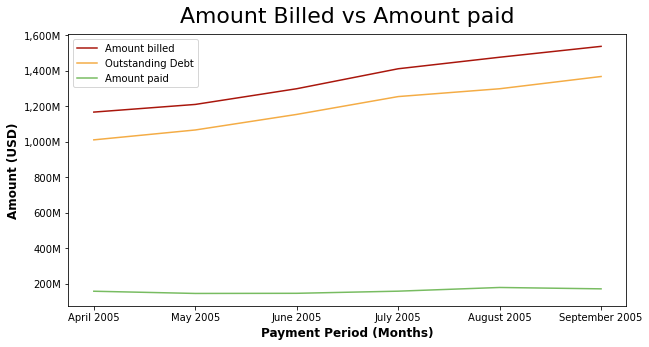

In [19]:
#creating series of bill amounts to be able to plot billing over time
apr_bsum = credit['Bill_Apr'].sum()
may_bsum = credit['Bill_May'].sum()
jun_bsum = credit['Bill_Jun'].sum()
jul_bsum = credit['Bill_Jul'].sum()
aug_bsum = credit['Bill_Aug'].sum()
sept_bsum = credit['Bill_Sept'].sum()
bill_sum = (apr_bsum, may_bsum, jun_bsum, jul_bsum, aug_bsum, sept_bsum)
bill_sum = np.array(bill_sum)

#creating series of payment amounts to be able to plot payment over time
apr_psum = credit['Pay_Amt_Apr'].sum()
may_psum = credit['Pay_Amt_May'].sum()
jun_psum = credit['Pay_Amt_Jun'].sum()
jul_psum = credit['Pay_Amt_Jul'].sum()
aug_psum = credit['Pay_Amt_Aug'].sum()
sept_psum = credit['Pay_Amt_Sept'].sum()
pay_sum = (apr_psum, may_psum, jun_psum, jul_psum, aug_psum, sept_psum)
pay_sum = np.array(pay_sum)

months = ([1,2,3,4,5,6])
monthly = plt.subplots(figsize=(10,5))
monthly = sns.lineplot(x= months, y=bill_sum, color='#a9160c', label='Amount billed')
monthly = sns.lineplot(x=months, y=(bill_sum-pay_sum), color='#f4ac45', label='Outstanding Debt')
monthly = sns.lineplot(x=months, y=pay_sum, color='#78BC61', label='Amount paid')
monthly.legend()
ylabels = ['{:,.0f}'.format(y) + 'M' for y in monthly.get_yticks()/1000000]
monthly.set_yticklabels(ylabels)
plt.title("Amount Billed vs Amount paid", y=1.02, fontsize=22)
plt.xlabel('Payment Period (Months)',{'size':'large','fontweight':'bold'})
monthly.set_xticks(ticks=[1,2,3,4,5,6], labels=['April 2005','May 2005', 'June 2005', 'July 2005', 'August 2005', 'September 2005'])
plt.ylabel('Amount (USD)',{'size':'large','fontweight':'bold'})

Even people who are not defaulting are not paying back all of their bills. 4 out of 5 people have not defaulted but they still have 4/5 of the total debt amount. Credit One should encourage their customers to pay more of their debt back, perhaps by offering incentives.

## Prediction Models

Now that I have explored the data and visualized the correlations between the variables, I can see if any of it will pan out for a prediction algorithm.

There are three models I want to try.
* A regression model to set the limit balance for a new customer.
* If that does not work, then a classifier model that can give us a range for the limit balance.
* A binary classifier that will predict whether a potential customer is likely to default.

### Regression

For the regression model, I will look at three different algorithms and choose the one that is the most accurate. The three algorithms I will test are the Random Forest Regressor, the Linear Regression, and the Support Vector Regression.

In [20]:
#Scikit-Learn Estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

#Model error metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Here I am creating a group so I can test three different algorithms at the same time.

In [21]:
#creating a list of different algorithms
algosclass = []
algosclass.append(('Random Forest Regressor',RandomForestRegressor()))
algosclass.append(('Linear Regression',LinearRegression()))
algosclass.append(('Support Vector Regression',SVR()))

In [22]:
#defining the dependent (X) and independent variables(y)
X = credit.iloc[:,~credit.columns.isin(['Limit_bal','Limit_Bins'])]
y=credit['Limit_bal']

In [23]:
#Program that will test the model with each algorithm then post the results into list 'results'
results = []
names = []
for name, model in algosclass:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.42782722473733353
Linear Regression 0.35003646184636666
Support Vector Regression -0.05045474891718501


Right off the bat, the Random Forest Regressor is the most accurate at about 44%.

In [24]:
X = credit.iloc[:,~credit.columns.isin(['Limit_bal','Limit_Bins'])]
y=credit['Limit_bal']

X_train, X_test, y_train, y_test = train_test_split(X, y)
algo = RandomForestRegressor(criterion='poisson',max_depth=12,random_state=700)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(r2_score(y_test, preds))

0.5017798183922529


These were the most accurate parameters found for the most accurate regression algorithm. Unfortunately, it is still only about 50% accurate.

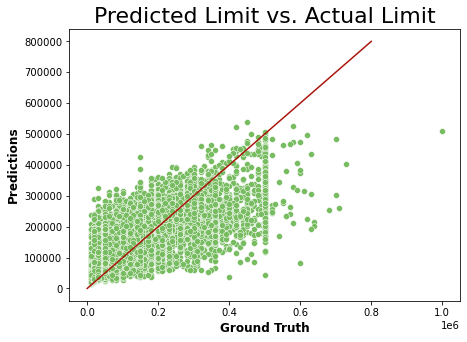

In [25]:
plt.subplots(figsize=(7,5))
sns.scatterplot(x=y_test, y=preds, color='#78BC61')
sns.lineplot(x=[0,100000,200000,300000,400000,500000,600000,700000,800000], 
             y=[0,100000,200000,300000,400000,500000,600000,700000,800000],
            color='#a9160c')
plt.title("Predicted Limit vs. Actual Limit", fontsize=22)
plt.xlabel('Ground Truth',{'size':'large','fontweight':'bold'})
plt.ylabel('Predictions',{'size':'large','fontweight':'bold'})
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(y/1000) + 'K'))
plt.show();

As we can see in this graph, there was a lot of variation within the guesses. The red line is where we would want the predictions to be. The algorithm tended to guess a lower balance than was accurate. This is the most accurate of the three algorithms. As a result, it is impossible to predict a limit balance as a regression.

### Classification Model

Since the regression model did not work so well, I'm going to try a classification model with the limit balance bins I made earlier. As with the regression model, I will test three different algorithms to see which one is the most accurate. I will be looking at the Random Forest Classifier, the Decision Tree Classifier, and the Gradient Boosting Classifier.

In [26]:
#Import classification models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [27]:
X = credit.iloc[:,~credit.columns.isin(['Limit_bal','Limit_Bins'])]
y=credit['Limit_Bins']

algos_class = []
algos_class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

D:\Users\jryba\anaconda3\envs\DataAnalyticsCourse\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
D:\Users\jryba\anaconda3\envs\DataAnalyticsCourse\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
D:\Users\jryba\anaconda3\envs\DataAnalyticsCourse\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Random Forest Classifier 0.49256666666666665
Decision Tree Classifier 0.3574333333333333
Gradient Boosting Classifier 0.1886


The Random Forest Classifier is the most accurate out of the three. So far it is not much more accurate than the regression model.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.007, 
                                                    random_state = 750, shuffle=True)
algo = RandomForestClassifier(max_depth=7)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

       10000       0.78      0.85      0.82        89
      100000       0.61      0.67      0.64        51
      200000       0.45      0.55      0.49        42
      300000       0.00      0.00      0.00        20
      400000       0.50      0.20      0.29         5
      500000       0.00      0.00      0.00         3

    accuracy                           0.64       210
   macro avg       0.39      0.38      0.37       210
weighted avg       0.58      0.64      0.61       210



These are the parameters that get it the highest, even though its test size is very small. You can see it excludes the bins above 500,000. Could I get more accurate by combining the bins above 500,000?

In [29]:
# Making weighted bins
Limit_Bins = pd.IntervalIndex.from_tuples([(10000,100000),(100000,200000),
                                           (200000,300000),(300000,400000),
                                           (400000,500000),(500000, 1000001)],
                                          closed='left')
credit['Limit_Bins'] = pd.cut(credit['Limit_bal'],Limit_Bins)

#Changing interval types to strings, changing the intervals to numbers
credit['Limit_Bins']=credit['Limit_Bins'].astype('string')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[10000, 100000)','10000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[100000, 200000)','100000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[200000, 300000)','200000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[300000, 400000)','300000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[400000, 500000)','400000')
credit['Limit_Bins']=credit['Limit_Bins'].replace('[500000, 1000001)','500000')

#Changing the type back to integers to allow for machine learning
credit['Limit_Bins']=credit['Limit_Bins'].astype('int64')
credit['Limit_Bins'].value_counts(ascending=True)

500000      928
400000     1147
300000     3042
200000     6033
100000     7400
10000     11450
Name: Limit_Bins, dtype: int64

In [30]:
X = credit.iloc[:,~credit.columns.isin(['Limit_bal','Limit_Bins'])]
y=credit['Limit_Bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, 
                                                    random_state = 750)
algo = RandomForestClassifier(max_depth=7)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

       10000       0.67      0.88      0.76      2745
      100000       0.52      0.44      0.47      1908
      200000       0.41      0.54      0.46      1544
      300000       0.42      0.09      0.15       772
      400000       0.54      0.07      0.12       291
      500000       0.60      0.06      0.11       240

    accuracy                           0.56      7500
   macro avg       0.52      0.34      0.34      7500
weighted avg       0.54      0.56      0.52      7500



In [31]:
X = credit.iloc[:,~credit.columns.isin(['Limit_bal','Limit_Bins'])]
y=credit['Limit_Bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.008, 
                                                    random_state = 750)
algo = RandomForestClassifier(max_depth=7)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

       10000       0.76      0.88      0.82       101
      100000       0.62      0.57      0.59        60
      200000       0.42      0.53      0.47        47
      300000       0.20      0.05      0.07        22
      400000       0.50      0.14      0.22         7
      500000       0.00      0.00      0.00         3

    accuracy                           0.62       240
   macro avg       0.42      0.36      0.36       240
weighted avg       0.59      0.62      0.60       240



In [32]:
model = RandomForestClassifier()
print(cross_val_score(model, X, y, cv=3)) 

[0.5556 0.5669 0.3696]


I was able to tweak the parameters to get the accuracy up to 56%, but it still would not be good enough to put into practice. I can conclude that it is impossible to predict a limit balance for potential customers.

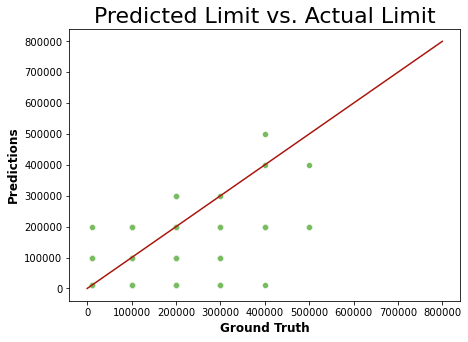

In [33]:
plt.subplots(figsize=(7,5))
sns.scatterplot(x=y_test, y=preds, color='#78BC61')
sns.lineplot(x=[0,100000,200000,300000,400000,500000,600000,700000,800000], 
             y=[0,100000,200000,300000,400000,500000,600000,700000,800000],
            color='#a9160c')
plt.title("Predicted Limit vs. Actual Limit", fontsize=22)
plt.xlabel('Ground Truth',{'size':'large','fontweight':'bold'})
plt.ylabel('Predictions',{'size':'large','fontweight':'bold'})
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(y/1000) + 'K'))
plt.show();

### Default

Like the models before, the first step I wil take is to test the three algorithms to see which one is the most accurate. Then I will change the parameters of the model to get the best answer I can.

In [34]:
X = credit.iloc[:,~credit.columns.isin(['Default'])]
y=credit['Default']

algos_class = []
algos_class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))

results = []
names = []
for name, model in algos_class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.6375000000000001
Decision Tree Classifier 0.5505666666666666
Gradient Boosting Classifier 0.5899333333333333


Without messing with the parameters, the Random Forest Classifier is the most accurate.

In [35]:
X = credit.iloc[:,~credit.columns.isin(['Default'])]
y=credit['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 500)
algo = RandomForestClassifier()
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.84      0.94      0.89      7041
           2       0.62      0.37      0.46      1959

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



Already the algorithm is 81% accurate. Let's see if we can't make it a bit more.

In [36]:
X = credit.iloc[:,~credit.columns.isin(['Default'])]
y=credit['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 750)
algo = RandomForestClassifier(max_depth=4)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.82      0.96      0.89      4667
           2       0.65      0.28      0.39      1333

    accuracy                           0.81      6000
   macro avg       0.74      0.62      0.64      6000
weighted avg       0.78      0.81      0.78      6000



In [37]:
X = credit.iloc[:,~credit.columns.isin(['Default'])]
y=credit['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .02, random_state = 750)
algo = RandomForestClassifier(max_depth=4)
model = algo.fit(X_train,y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.85      0.96      0.90       482
           2       0.68      0.32      0.44       118

    accuracy                           0.84       600
   macro avg       0.77      0.64      0.67       600
weighted avg       0.82      0.84      0.81       600



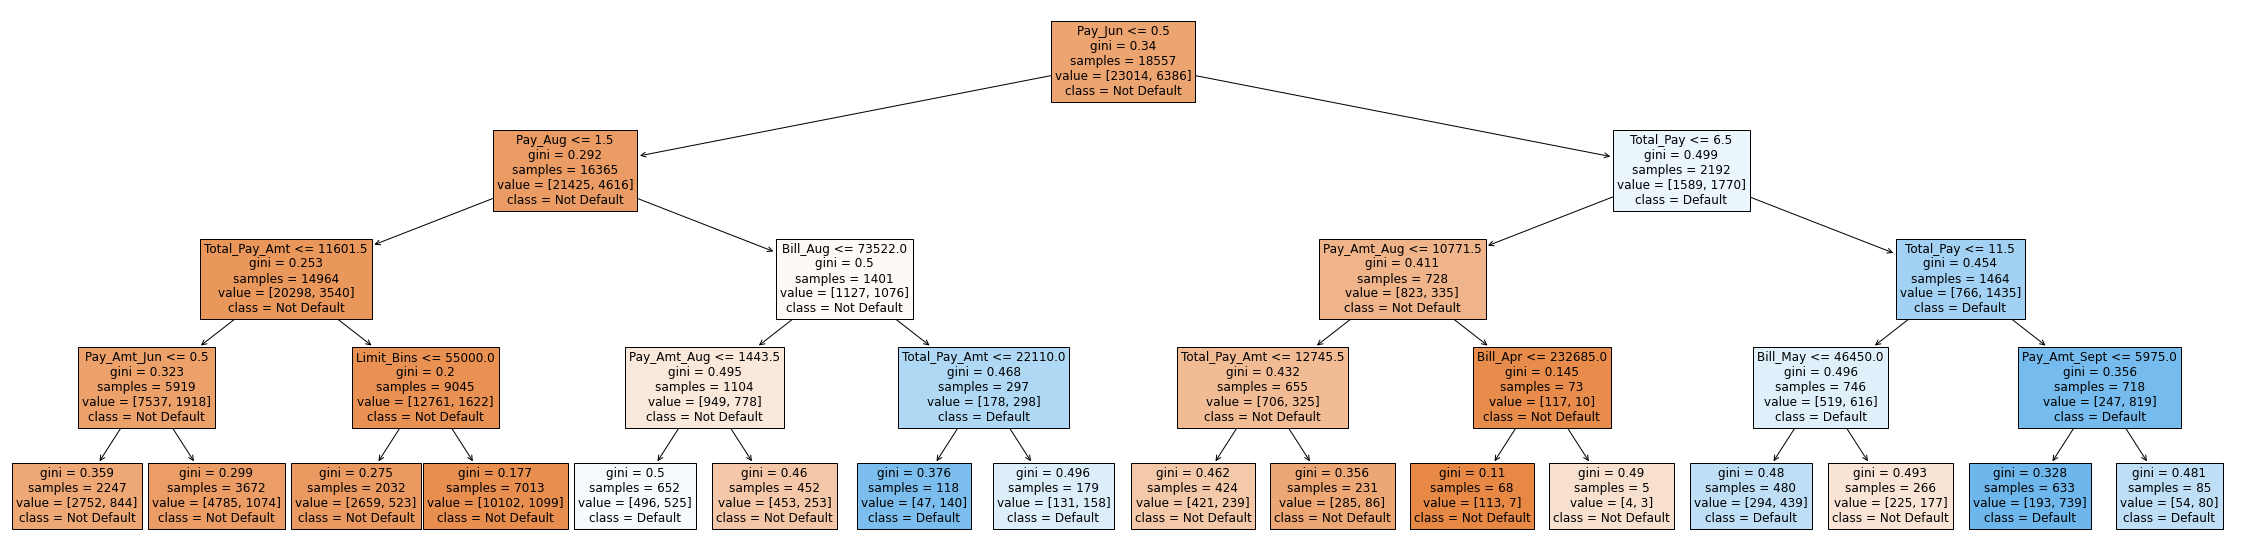

In [38]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(40,10))
tree = plot_tree(model.estimators_[5], feature_names=X.columns,class_names=['Not Default', 'Default'], filled=True, fontsize=12)

I was able to increase the accuracy to 84%. This is good enough to use to try to predict new customers who will default. 

As I suspected from the analysis, the payment status was the variable that best predicted whether someone would default. 

## Conclusion

Although it was impossible to create an algorithm to set credit limits for new customers, I was able to predict customers who were likely to default with 84% accuracy. I was also able to find some data that may help Credit One's business that was not related to the question at hand. They would do well to encourage those who did not default to decrease their debt instead of paying the minimum payment. I believe that this finding will give Credit One an idea for how they can conduct their business in the future.